# Imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from pathlib import Path

data_path = Path("/content/gdrive/MyDrive/alabuga_hack/")

In [ ]:
!unzip {data_path / "lenta_news.zip"} -d {data_path}

Archive:  /content/gdrive/MyDrive/alabuga_hack/lenta_news.zip
  inflating: /content/gdrive/MyDrive/alabuga_hack/lenta_ru_news_2019_2023.csv  


In [ ]:
%%capture
!pip install natasha
!pip install pymystem3

In [ ]:
from natasha import Doc, NewsNERTagger, NewsEmbedding, Segmenter, MorphVocab,\
                    NewsMorphTagger, NewsSyntaxParser

from pymystem3 import Mystem

In [ ]:
%%capture

# NEED TO REBOOT AFTER

!pip install datasets
!pip install accelerate -U
!pip install pyarrow==15.0.2

In [ ]:
%%capture

!pip install torcheval

In [ ]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from collections import defaultdict

from typing import Dict

# EDA

In [ ]:
df = pd.read_csv(data_path / "lenta_ru_news_2019_2023.csv")

In [ ]:
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Фотография,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15


# Extracting ORG-related text

## Step-by-step

In [ ]:
morph_vocab = MorphVocab()

In [ ]:
text = df.sample(1).text.values[0]

In [ ]:
doc = Doc(text)

In [ ]:
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)
segmenter = Segmenter()
morph_tagger = NewsMorphTagger(emb)

In [ ]:
doc.segment(segmenter)

In [ ]:
doc.tag_morph(morph_tagger)

In [ ]:
doc.tag_ner(ner_tagger)

In [ ]:
doc.spans[0].normalize(morph_vocab)
doc.spans[0]

DocSpan(start=49, stop=55, type='LOC', text='Одессе', tokens=[...], normal='Одесса')

In [ ]:
doc.sents[0]

DocSent(stop=164, text='Заброшенный стадион «Фрезер», расположенный на те..., tokens=[...], spans=[...])

In [ ]:
Mystem().lemmatize("у меня нет аккаунта в Сбере")

['у', ' ', 'я', ' ', 'нет', ' ', 'аккаунт', ' ', 'в', ' ', 'сбера', '\n']

In [ ]:
orgs = defaultdict(list)

In [ ]:
mstem = Mystem()

In [ ]:
for sent in doc.sents:
    for span in sent.spans:
        if span.type == "ORG":
            orgs["".join(mstem.lemmatize(span.text)).strip()].append(sent.text)

In [ ]:
orgs = {k: " ".join(v) for k, v in orgs.items()}

In [ ]:
orgs

{'фрезер': 'Заброшенный стадион «Фрезер», расположенный на территории лесопарка «Кусково», планируют превратить в многофункциональный кластер для занятий разными видами спорта. «Смотря на состояние территории «Фрезера» сегодня, трудно представить, что здесь когда-то был стадион. Каждый новый такой объект, по его словам, найдет своих спортсменов среди жителей города самых разных возрастов.Стадион завода «Фрезер» открылся в Вешняках в начале 30-х годов прошлого века.',
 'федеральный центр подготовка спортивный резерв': 'Они дают посетителям парков возможность не только культурно отдохнуть, но и развиваться физически, укреплять свое здоровье», — отметил замглавы службы поддержки кадров и организаций Федерального центра подготовки спортивного резерва Анатолий Новиков.'}

## API

In [ ]:
from natasha import Doc, NewsNERTagger, NewsEmbedding, Segmenter, MorphVocab,\
                    NewsMorphTagger, NewsSyntaxParser
from pymystem3 import Mystem
from collections import defaultdict
from typing import Dict

In [ ]:
def get_orgs_text(text: str) -> Dict[str, str]:
    """
    Gets text as parameter and returns all sentences, that related with organization.'

    Output format:
    {
        "OrgName 1": "Text",
        "OrgName 2": "Text"
    }
    """
    doc = Doc(text)

    emb = NewsEmbedding()
    ner_tagger = NewsNERTagger(emb)
    segmenter = Segmenter()
    morph_tagger = NewsMorphTagger(emb)
    syntax_parser = NewsSyntaxParser(emb)
    morph_vocab = MorphVocab()

    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)

    mstem = Mystem()

    orgs = defaultdict(list)

    for sent in doc.sents:
        for span in sent.spans:
            if span.type == "ORG":
                span.normalize(morph_vocab)
                orgs[span.normal].append(sent.text)

    return {k: " ".join(v) for k, v in orgs.items()}

In [ ]:
get_orgs_text(df.sample(1).text.values[0])

{'Лента.ру': 'Об этом во вторник, 25 октября, «Ленте.ру» сообщила официальный представитель регионального управления Следственного комитета России (СКР) Юлия Арбузова. Как рассказала «Ленте.ру» официальный представитель краевой прокуратуры Олеся Климова, придя в лес, мальчик решил испугать друга выстрелом из незаряженного нижнего ствола.',
 'Следственный комитет': 'Об этом во вторник, 25 октября, «Ленте.ру» сообщила официальный представитель регионального управления Следственного комитета России (СКР) Юлия Арбузова.',
 'СКР': 'Ход расследования этого дела по поручению главы СКР Александра Бастрыкина находился на контроле в центральном аппарате ведомства.'}

In [ ]:
data = df.text.values[:100]

In [ ]:
%%time
for t in tqdm(data):
    get_orgs_text(t)

100%|██████████| 100/100 [01:52<00:00,  1.13s/it]

CPU times: user 1min 39s, sys: 24.2 s, total: 2min 4s
Wall time: 1min 52s


# Labeling

In [ ]:
from IPython.display import clear_output

## Example

In [ ]:
d = get_orgs_text(df.sample().text.values[0])
ml =  []
for t in d.values():
    print(f"Оцените тональность (1 - positive): {t}")
    s = input()
    ml.append(s)
    clear_output()

# Classifier fine-tuning

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(data_path / "train_data.csv", sep="\t")

In [ ]:
df = df[df.entity_tag == "ORGANIZATION"]

In [ ]:
df.drop(df[df.label == 0].sample(3700).index, inplace=True)

In [ ]:
df.label.value_counts()

label
 0    4774
-1    1007
 1     856
Name: count, dtype: int64

In [ ]:
df.head()

,sentence,entity,entity_tag,entity_pos_start_rel,entity_pos_end_rel,label
13,Apple и Samsung нарушали патенты друг друга,Samsung,ORGANIZATION,8,15,-1
31,В частности Винник признался в отмывании денеж...,BTC-e,ORGANIZATION,259,264,0
33,Газета Global Times цитирует недовольных приго...,Global Times,ORGANIZATION,7,19,0
35,Как написал Шмидт в недавней колонке в журнале...,Google,ORGANIZATION,84,90,0
50,"Как отмечает Bloomberg, Лилиан Беттанкур жила ...",Bloomberg,ORGANIZATION,13,22,0


In [ ]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array([t.replace(ent, "[MASK]") for t, ent, *_ in df.itertuples(index=False)]),
    torch.tensor(df.label.values + 1),
    test_size=0.2,
    stratify=df.label)

In [ ]:
seq_len_train = [len(str(i).split()) for i in x_train]
seq_len_test = [len(str(i).split()) for i in x_test]
max_seq_len = max(max(seq_len_test), max(seq_len_train))
max_seq_len

62

In [ ]:
from collections import Counter

In [ ]:
cnt = Counter(df.label.values + 1)
counts_class = [cnt[i] for i in range(3)]
weights_class = [max(counts_class) / x * 2 for x in counts_class]
weights_class[1] = 1.0

In [ ]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
# tokenizer = BertTokenizer.from_pretrained(data_path / "bert2")

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    x_train,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    x_test,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [ ]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Data(tokens_train, y_train)
test_dataset = Data(tokens_test, y_test)

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
def compute_metrics(pred):
    labels = torch.tensor(pred.label_ids)[:, 0]
    preds = torch.tensor(pred.predictions.argmax(-1))
    # print(labels, preds)
    f1 = multiclass_f1_score(preds, labels, num_classes=3, average="macro")
    return {'F1': f1}

In [ ]:
from torch import nn


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights_class))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir = '/content/results', #Выходной каталог
    num_train_epochs = 20, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay = 0.01, #Понижение весов
    logging_dir = '/content/logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 0.01, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny', num_labels=3).to("cpu")
# model = BertForSequenceClassification.from_pretrained(data_path / "bert2", num_labels=3).to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = CustomTrainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  compute_metrics = compute_metrics)

In [ ]:
# model.dropout.p = 0.5

In [ ]:
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,1.120500,0.975580,0.352632
2,1.071900,1.154217,0.278218
3,1.062600,0.985670,0.315292
4,1.050500,1.027591,0.416860
5,1.059200,0.985188,0.443744
6,1.058700,1.039473,0.293253
7,1.033300,0.964067,0.327749
8,1.035100,0.922334,0.361578
9,1.018800,0.948943,0.365781
10,1.014900,1.017578,0.395478


TrainOutput(global_step=13280, training_loss=1.0153797793101116, metrics={'train_runtime': 1258.4223, 'train_samples_per_second': 84.375, 'train_steps_per_second': 10.553, 'total_flos': 94827957698160.0, 'train_loss': 1.0153797793101116, 'epoch': 20.0})

In [ ]:
def get_prediction():
    test_pred = trainer.predict(test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels
pred = get_prediction()

In [ ]:
model_path = data_path / "bert4"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/gdrive/MyDrive/alabuga_hack/bert4/tokenizer_config.json',
 '/content/gdrive/MyDrive/alabuga_hack/bert4/special_tokens_map.json',
 '/content/gdrive/MyDrive/alabuga_hack/bert4/vocab.txt',
 '/content/gdrive/MyDrive/alabuga_hack/bert4/added_tokens.json')

In [ ]:
inf_tok = tokenizer.batch_encode_plus(
    ["В [MASK] нашли 7 трупов котов",
     "Крупнейшая в мире торговая сеть Walmart пытается через суд взыскать с платёжной системы [MASK] пять миллиардов долларов США за завышение комиссий."],
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
trainer.predict(Data(inf_tok, np.array([0, 0])))

PredictionOutput(predictions=array([[-0.74928606,  1.0628929 , -0.32219967],
       [ 0.47693864, -0.23191601, -0.2580368 ]], dtype=float32), label_ids=array([[0],
       [0]]), metrics={'test_loss': 1.4186131954193115, 'test_F1': 0.3333333432674408, 'test_runtime': 0.0393, 'test_samples_per_second': 50.932, 'test_steps_per_second': 25.466})

In [ ]:
!ls {data_path}

alabuga_hack_baseline_ner.ipynb		 lenta_news.zip		      sample.csv  train_data.csv
araneum_upos_skipgram_300_2_2018.vec.gz  lenta_ru_news_2019_2023.csv  test.json   train.json


In [ ]:
# val_df = pd.read_csv(data_path / "validation_data_labeled.csv", sep="\t")
val_df = pd.read_csv("validation_data_labeled.csv", sep="\t")

In [ ]:
val_df.head()

,sentence,entity,entity_tag,entity_pos_start_rel,entity_pos_end_rel,label
0,Представители вооруженных сил Южной Кореи сооб...,вооруженных сил Южной Кореи,ORGANIZATION,14,41,0
1,В 2012 году Мурси победил во втором туре прези...,президентских,PROFESSION,41,54,0
2,В заключительной церемонии фестиваля примут уч...,журналисты,PROFESSION,129,139,0
3,"В своём последнем слове Лапшин заявил, что его...",Азербайджана,COUNTRY,66,78,0
4,Однако после совещания судейского корпуса было...,Спартака,ORGANIZATION,113,121,0


In [ ]:
x_val = [t.replace(ent, "[MASK]") for t, ent, *_ in val_df.itertuples(index=False)]
y_val = val_df.label.values + 1

In [ ]:
val_tok = tokenizer.batch_encode_plus(
    x_val,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [ ]:
data_val = Data(val_tok, y_val)

In [ ]:
trainer.evaluate(data_val)

{'eval_loss': 1.0335408449172974,
 'eval_F1': 0.5707605481147766,
 'eval_runtime': 26.1573,
 'eval_samples_per_second': 108.765,
 'eval_steps_per_second': 13.61,
 'epoch': 3.0}

# Bin clf

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(data_path / "train_data.csv", sep="\t")

In [ ]:
df.label.value_counts()

label
 0    4774
-1    1007
 1     856
Name: count, dtype: int64

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

## First

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array([t.replace(ent, "[MASK]") for t, ent, *_ in df.itertuples(index=False)]),
    torch.tensor([0 if x == 0 else 1 for x in df.label.values]),
    test_size=0.2,
    stratify=df.label)

In [ ]:
max_seq_len = 62

In [ ]:
from collections import Counter

In [ ]:
cnt = Counter([0 if x == 0 else 1 for x in df.label.values])
counts_class = [cnt[i] for i in range(2)]
weights_class = [max(counts_class) / x for x in counts_class]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
# tokenizer = BertTokenizer.from_pretrained(data_path / "bert2")

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    x_train,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    x_test,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [ ]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Data(tokens_train, y_train)
test_dataset = Data(tokens_test, y_test)

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
def compute_metrics(pred):
    labels = torch.tensor(pred.label_ids)[:, 0]
    preds = torch.tensor(pred.predictions.argmax(-1))
    # print(labels, preds)
    f1 = multiclass_f1_score(preds, labels, num_classes=2, average="macro")
    return {'F1': f1}

In [ ]:
from torch import nn


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights_class))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir = '/content/results', #Выходной каталог
    num_train_epochs = 20, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay = 0.005, #Понижение весов
    logging_dir = '/content/logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 0.01, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model1 = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny', num_labels=2).to("cpu")
# model = BertForSequenceClassification.from_pretrained(data_path / "bert2", num_labels=3).to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer1 = CustomTrainer(model=model1,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  compute_metrics = compute_metrics)

In [ ]:
for param in model1.bert.parameters():
    param.requires_grad = False

In [ ]:
trainer1.train()

Epoch,Training Loss,Validation Loss,F1
1,0.726500,0.720536,0.508087
2,0.725100,0.660811,0.572909
3,0.705900,0.671564,0.601187
4,0.695900,0.703091,0.581838
5,0.698600,0.654728,0.608350
6,0.695500,0.683575,0.552197
7,0.691600,0.690363,0.589024
8,0.701100,0.659320,0.606711
9,0.680900,0.697007,0.562277
10,0.679000,0.704495,0.526023


TrainOutput(global_step=13280, training_loss=0.6786331935101245, metrics={'train_runtime': 1460.5706, 'train_samples_per_second': 72.698, 'train_steps_per_second': 9.092, 'total_flos': 94815594523680.0, 'train_loss': 0.6786331935101245, 'epoch': 20.0})

In [ ]:
model_path = data_path / "1bert2"
model1.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/gdrive/MyDrive/alabuga_hack/1bert2/tokenizer_config.json',
 '/content/gdrive/MyDrive/alabuga_hack/1bert2/special_tokens_map.json',
 '/content/gdrive/MyDrive/alabuga_hack/1bert2/vocab.txt',
 '/content/gdrive/MyDrive/alabuga_hack/1bert2/added_tokens.json')

## Second

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    [t.replace(ent, "[MASK]") for t, ent, *_ in df[df.label != 0].itertuples(index=False)],
    [0 if x == -1 else 1 for x in df[df.label != 0].label.values],
    test_size=0.2,
    stratify=df[df.label != 0].label)

In [ ]:
max_seq_len = 62

In [ ]:
from collections import Counter

In [ ]:
cnt = Counter([0 if x == -1 else 1 for x in df[df.label != 0].label.values])
counts_class = [cnt[i] for i in range(2)]
weights_class = [max(counts_class) / x for x in counts_class]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
# tokenizer = BertTokenizer.from_pretrained(data_path / "bert2")

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    x_train,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    x_test,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [ ]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Data(tokens_train, y_train)
test_dataset = Data(tokens_test, y_test)

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
def compute_metrics(pred):
    labels = torch.tensor(pred.label_ids)[:, 0]
    preds = torch.tensor(pred.predictions.argmax(-1))
    # print(labels, preds)
    f1 = multiclass_f1_score(preds, labels, num_classes=2, average="macro")
    return {'F1': f1}

In [ ]:
from torch import nn


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights_class))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir = '/content/results', #Выходной каталог
    num_train_epochs = 40, #Кол-во эпох для обучения
    per_device_train_batch_size = 8, #Размер пакета для каждого устройства во время обучения
    per_device_eval_batch_size = 8, #Размер пакета для каждого устройства во время валидации
    weight_decay = 0.01, #Понижение весов
    logging_dir = '/content/logs', #Каталог для хранения журналов
    load_best_model_at_end = True, #Загружать ли лучшую модель после обучения
    learning_rate = 0.01, #Скорость обучения
    evaluation_strategy ='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    logging_strategy = 'epoch', #Логирование после каждой эпохи
    save_strategy = 'epoch', #Сохранение после каждой эпохи
    save_total_limit = 1,
    seed=21)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model2 = BertForSequenceClassification.from_pretrained('cointegrated/rubert-tiny', num_labels=2).to("cpu")
# model = BertForSequenceClassification.from_pretrained(data_path / "bert2", num_labels=3).to("cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer2 = CustomTrainer(model=model2,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = test_dataset,
                  compute_metrics = compute_metrics)

In [ ]:
for param in model2.bert.parameters():
    param.requires_grad = False

In [ ]:
trainer2.train()

Epoch,Training Loss,Validation Loss,F1
1,0.623200,0.663235,0.649843
2,0.592200,0.545470,0.704489
3,0.578800,0.675015,0.617344
4,0.583600,0.576101,0.691689
5,0.570200,0.588586,0.694368
6,0.574900,0.564747,0.693874
7,0.566500,0.563910,0.720728
8,0.559500,0.607639,0.645790
9,0.590700,0.546966,0.715718
10,0.574300,0.564655,0.707640


TrainOutput(global_step=7480, training_loss=0.5514320291937354, metrics={'train_runtime': 833.092, 'train_samples_per_second': 71.541, 'train_steps_per_second': 8.979, 'total_flos': 53221034409600.0, 'train_loss': 0.5514320291937354, 'epoch': 40.0})

In [ ]:
model_path = data_path / "2bert2"
model1.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/gdrive/MyDrive/alabuga_hack/2bert2/tokenizer_config.json',
 '/content/gdrive/MyDrive/alabuga_hack/2bert2/special_tokens_map.json',
 '/content/gdrive/MyDrive/alabuga_hack/2bert2/vocab.txt',
 '/content/gdrive/MyDrive/alabuga_hack/2bert2/added_tokens.json')

# GPT Labeling

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe_ner = pipeline("token-classification", model="yqelz/xml-roberta-large-ner-russian")

In [ ]:
d = pipe_ner("Apple и Xaomi крадут патенты друг друга", aggregation_strategy="first")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
texts = df.text.sample(100).values
t = df.text.sample(1).values[0]

In [ ]:
%%time

d = pipe(t)

CPU times: user 7.35 s, sys: 34.9 ms, total: 7.38 s
Wall time: 10.1 s


In [ ]:
%%time

d = pipe("Apple и Xaomi крадут патенты друг друга")

CPU times: user 523 ms, sys: 2.17 ms, total: 526 ms
Wall time: 1.48 s


In [ ]:
%%time

d = get_orgs_text(t)

for ts in d.values():
    pipe(ts)

CPU times: user 3.16 s, sys: 399 ms, total: 3.56 s
Wall time: 5.25 s


In [ ]:
ner_df = pd.DataFrame(columns=["text_id", "sentence_id", "sentence", "entity", "start_pos", "end_pos", "label"])

In [ ]:
ner_df.drop(ner_df.index, inplace=True)

In [ ]:
from google.colab import output

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe_clf = pipeline("text-classification", model="seara/rubert-tiny2-russian-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pipe_clf("Текст")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'label': 'neutral', 'score': 0.9071831107139587}]

In [ ]:
%%time

import warnings
warnings.filterwarnings("ignore")

start, total = 150, 100

for text_id, text in enumerate(df.loc[start:start + total, "text"]):
    doc = Doc(text)

    emb = NewsEmbedding()
    ner_tagger = NewsNERTagger(emb)
    segmenter = Segmenter()

    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    for sent_id, sent in enumerate(doc.sents):
        if not any(map(lambda x: x.type == "ORG", sent.spans)):
            continue

        sentim = pipe_clf(sent.text)[0]["label"]
        if sentim == "neutral":
            continue

        preds = pipe_ner(sent.text, aggregation_strategy="first")

        for span in preds:
            if span["entity_group"] != "ORG":
                continue
            word = sent.text[span["start"]:span["end"]]

            if sentim != "neutral":
                output.clear()

                print("Выбери тональность в отношении компании, обозначенной *звёздочками* (0-отриц, 1-нейтр, 2-полож, 3-пропустить):")
                print(sent.text.replace(word, "*" + word + "*"))
                label = input()
            else:
                label = 1

            if label == "q":
                break

            if label == "3":
                continue

            ner_df.loc[ner_df.shape[0]] = (text_id + start, sent_id, sent.text, word, span["start"], span["end"], int(label) - 1)
        if label == "q":
            break
    if label == "q":
        break

warnings.resetwarnings()

Выбери тональность в отношении компании, обозначенной *звёздочками* (0-отриц, 1-нейтр, 2-полож, 3-пропустить):
В июне 2017-го рейс *United Airlines* из Нью-Йорка в Венецию пришлось отменить из-за масштабной утечки топлива у лайнера.
0
CPU times: user 1min 19s, sys: 14.2 s, total: 1min 33s
Wall time: 4min 46s


In [ ]:
ner_df.label.value_counts()

label
 0    546
-1     34
 1     23
Name: count, dtype: int64

# Catboost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
df_train = pd.read_csv(data_path / "train_data.csv", sep="\t")

In [ ]:
X = df_train[["sentence", "entity"]]
y = df_train.label.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

In [ ]:
model = CatBoostClassifier(
    iterations=300,
    random_state=42,
    learning_rate=0.1,
    depth=4,
    l2_leaf_reg=5,
    loss_function="MultiClass",
    text_features=("sentence", "entity",)
)

In [ ]:
grid = {'learning_rate': [0.03, 0.1],
       'depth': [4, 6, 10],
       'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                      X=X_test,
                                      y=y_test,)

# grid_search_result = {
#     "learning_rate": 0.1,
#     "depth": 4,
#     "l2_leaf_reg": 5
# }

In [ ]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 1.0353042	test: 1.0352901	best: 1.0352901 (0)	total: 347ms	remaining: 1m 43s
1:	learn: 0.9867608	test: 0.9867007	best: 0.9867007 (1)	total: 558ms	remaining: 1m 23s
2:	learn: 0.9464107	test: 0.9453272	best: 0.9453272 (2)	total: 769ms	remaining: 1m 16s
3:	learn: 0.9157941	test: 0.9150518	best: 0.9150518 (3)	total: 992ms	remaining: 1m 13s
4:	learn: 0.8900962	test: 0.8879241	best: 0.8879241 (4)	total: 1.2s	remaining: 1m 10s
5:	learn: 0.8705971	test: 0.8685329	best: 0.8685329 (5)	total: 1.42s	remaining: 1m 9s
6:	learn: 0.8535521	test: 0.8501601	best: 0.8501601 (6)	total: 1.64s	remaining: 1m 8s
7:	learn: 0.8404748	test: 0.8373308	best: 0.8373308 (7)	total: 1.86s	remaining: 1m 7s
8:	learn: 0.8298358	test: 0.8269089	best: 0.8269089 (8)	total: 2.07s	remaining: 1m 6s
9:	learn: 0.8206879	test: 0.8180127	best: 0.8180127 (9)	total: 2.28s	remaining: 1m 6s
10:	learn: 0.8133512	test: 0.8110056	best: 0.8110056 (10)	total: 2.48s	remaining: 1m 5s
11:	learn: 0.8070298	test: 0.8049871	best: 0.804

# word2vec


In [ ]:
import re
import warnings
import pymystem3

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import KeyedVectors

import pymystem3
import nltk
from nltk.corpus import stopwords
from string import punctuation
import re
#from sentence_transformers import SentenceTransformer
from gensim.models import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer

#from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
import pandas as pd

In [ ]:
train = pd.read_csv(data_path / "train_data.csv", sep="\t")

In [ ]:
!wget https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz

--2024-07-02 22:27:18--  https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 394697055 (376M) [application/x-gzip]
Saving to: ‘ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz’

ruwikiruscorpora_up 100%[===================>] 376.41M  15.7MB/s    in 26s     

2024-07-02 22:27:46 (14.3 MB/s) - ‘ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz’ saved [394697055/394697055]



In [ ]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz', binary=False)

In [ ]:
mystem_tags_to_upos = {
    "A": "ADJ",
    "ADV": "ADV",
    "ADVPRO": "ADV",
    "ANUM": "ADJ",
    "APRO": "DET",
    "COM": "ADJ",
    "CONJ": "SCONJ",
    "INTJ": "INTJ",
    "NONLEX": "X",
    "NUM": "NUM",
    "PART": "PART",
    "PR": "ADP",
    "S": "NOUN",
    "SPRO": "PRON",
    "UNKN": "X",
    "V": "VERB",
}
mystem = pymystem3.mystem.Mystem()
def get_word2vec_embeddings(document):
    zero_array = np.zeros(300)

    tokens = mystem.analyze(document)
    document_vec = list()

    for token in tokens:
        if token["text"].strip() == "":
            continue
        if not token.get("analysis"):
            continue
        lemma = token["analysis"][0]["lex"]
        part_speech = token["analysis"][0]["gr"].split(",")[0].replace("=", "")
        part_speech = re.match(r"^[A-Z]*", part_speech).group(0)
        upos = mystem_tags_to_upos[part_speech]
        word = f"{lemma}_{upos}"

        try:
            word_vec = word2vec_model[word]
        except KeyError:
            document_vec.append(zero_array)
            continue
        document_vec.append(word_vec)
    if not document_vec:
        document_vec.append(zero_array)
    return np.mean(document_vec, axis=0)

In [ ]:
embs = [get_word2vec_embeddings(txt) for txt in train['sentence']]

In [ ]:
train['w2v'] = embs

In [ ]:
train

,sentence,entity,entity_tag,entity_pos_start_rel,entity_pos_end_rel,label,w2v
0,"Джеймс «Бадди» Макгирт (James (Buddy) McGirt, ...",спортсмена,PROFESSION,86,96,0,"[0.016083214032862867, -0.01815971452742815, 0..."
1,«За всю нашу долгую карьеру нам довелось играт...,музыкантов,PROFESSION,258,268,0,"[-0.000664636344564232, -0.002092659399336712,..."
2,"Ранее, 7 декабря, толпа болельщиков перекрыла ...",Егоре Свиридове,PERSON,175,190,0,"[0.013765621063267362, 0.001627069175371836, 0..."
3,"В субботу, 21 июля 2018 года, на арене СК «Оли...",россиянина,NATIONALITY,122,132,0,"[0.005697673905397887, -0.004136065193249479, ..."
4,Представитель талибов Забиулла Муджахид в твит...,американских захватчика,PROFESSION,109,132,-1,"[0.010109333365800836, 0.002532476315363532, 0..."
...,...,...,...,...,...,...,...
6632,"Всего за две недели до этой катастрофы, в Конг...",российский,NATIONALITY,91,101,0,"[-0.013202875094975752, -0.006599500047741458,..."
6633,"Следствие показало, что Картер бил Аллена, в т...",Аллена,PERSON,35,41,-1,"[-0.005496687954291701, -0.002737624861765653,..."
6634,"С другой стороны, вполне вероятна эволюция ХАМ...",ХАМАС,ORGANIZATION,43,48,0,"[0.0286965288413579, 0.012215059113633983, 0.0..."
6635,"Тем не менее, войска боснийских сербов уничтож...",сербов,NATIONALITY,32,38,0,"[-0.020338400080800057, -0.006295099854469299,..."


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
X = train['w2v'].values
y = train.label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

In [ ]:
model = CatBoostClassifier(
    iterations=300,
    random_state=42,
    learning_rate=0.1,
    depth=4,
    l2_leaf_reg=5,
    loss_function="MultiClass",
    embedding_features=[0]

)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=X_test,
                                       y=y_test,)

Выходные данные были обрезаны до нескольких последних строк (5000).
186:	learn: 0.7882517	test: 0.7806939	best: 0.7806939 (186)	total: 218ms	remaining: 132ms
187:	learn: 0.7882514	test: 0.7806930	best: 0.7806930 (187)	total: 219ms	remaining: 130ms
188:	learn: 0.7882511	test: 0.7806921	best: 0.7806921 (188)	total: 220ms	remaining: 129ms
189:	learn: 0.7882509	test: 0.7806913	best: 0.7806913 (189)	total: 220ms	remaining: 128ms
190:	learn: 0.7882506	test: 0.7806906	best: 0.7806906 (190)	total: 221ms	remaining: 126ms
191:	learn: 0.7882504	test: 0.7806898	best: 0.7806898 (191)	total: 222ms	remaining: 125ms
192:	learn: 0.7882502	test: 0.7806891	best: 0.7806891 (192)	total: 223ms	remaining: 124ms
193:	learn: 0.7882500	test: 0.7806884	best: 0.7806884 (193)	total: 224ms	remaining: 122ms
194:	learn: 0.7882498	test: 0.7806878	best: 0.7806878 (194)	total: 225ms	remaining: 121ms
195:	learn: 0.7882496	test: 0.7806871	best: 0.7806871 (195)	total: 226ms	remaining: 120ms
196:	learn: 0.7882495	test: 0.78

In [ ]:
grid_search_result ={'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 9}

In [ ]:
model = CatBoostClassifier(
    iterations=300,
    random_state=42,
    learning_rate=0.1,
    depth=4,
    l2_leaf_reg=9,
    loss_function="MultiClass",
    embedding_features=[0]
)

In [ ]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 1.0355527	test: 1.0349705	best: 1.0349705 (0)	total: 7.98ms	remaining: 2.38s
1:	learn: 0.9852351	test: 0.9842698	best: 0.9842698 (1)	total: 17.8ms	remaining: 2.65s
2:	learn: 0.9445569	test: 0.9436363	best: 0.9436363 (2)	total: 24.8ms	remaining: 2.45s
3:	learn: 0.9123327	test: 0.9120179	best: 0.9120179 (3)	total: 31.2ms	remaining: 2.31s
4:	learn: 0.8863809	test: 0.8855551	best: 0.8855551 (4)	total: 41ms	remaining: 2.42s
5:	learn: 0.8643356	test: 0.8655365	best: 0.8655365 (5)	total: 45.7ms	remaining: 2.24s
6:	learn: 0.8464628	test: 0.8489545	best: 0.8489545 (6)	total: 48.2ms	remaining: 2.02s
7:	learn: 0.8321864	test: 0.8344691	best: 0.8344691 (7)	total: 58.7ms	remaining: 2.14s
8:	learn: 0.8202601	test: 0.8224452	best: 0.8224452 (8)	total: 61.1ms	remaining: 1.98s
9:	learn: 0.8099397	test: 0.8119782	best: 0.8119782 (9)	total: 63.6ms	remaining: 1.84s
10:	learn: 0.8009236	test: 0.8043111	best: 0.8043111 (10)	total: 73.5ms	remaining: 1.93s
11:	learn: 0.7937373	test: 0.7966901	best: 

# BERT Embeddings

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("feature-extraction", model="cointegrated/rubert-tiny",
                tokenize_kwargs={"max_length": 61, "padding": "max_length"})

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
max_seq_len = 61

In [ ]:
df = pd.read_csv(data_path / "train_data.csv", sep="\t")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
texts = [t.replace(ent, "[MASK]") for t, ent, *_ in df.itertuples(index=False)]

In [ ]:
embs = pipe(texts)

In [ ]:
data = np.zeros((df.shape[0], 61, 1024))

In [ ]:
for i, emb in tqdm(enumerate(embs)):
    data[i, :len(emb)] = np.array

KeyboardInterrupt: 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(),
    torch.tensor(df.label.values + 1),
    test_size=0.2,
    stratify=df.label)

# Evaluating

In [ ]:
import torch
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
df_val = pd.read_csv(data_path / "validation_data_labeled.csv", sep='\t')

## RuBERT

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe_clf = pipeline("text-classification", model="seara/rubert-tiny2-russian-sentiment")

In [ ]:
preds = np.array([{"positive": 2, "negative": 0, "neutral": 1}[pipe_clf(t)[0]["label"]] for t in df_val.sentence])

## Catboost

In [ ]:
preds = model.predict(df_val[["sentence", "entity"]])[:, 0]
preds += 1

## Catboost + w2v

In [ ]:
from catboost import Pool

In [ ]:
df_val["embs"] = [get_word2vec_embeddings(txt) for txt in df_val.sentence]
preds = model.predict(Pool(data=df_val.embs.values, embedding_features=[0])) + 1
preds = preds[:, 0]

## RuBERT + masking

In [ ]:
x_val = [t.replace(ent, "[MASK]") for t, ent, *_ in df_val.itertuples(index=False)]
y_val = df_val.label.values + 1

In [ ]:
val_tok = tokenizer.batch_encode_plus(
    x_val,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [ ]:
data_val = Data(val_tok, y_val)

In [ ]:
preds = trainer.predict(data_val).predictions.argmax(-1)

## RuBert bin clf

In [ ]:
x_val = [t.replace(ent, "[MASK]") for t, ent, *_ in df_val.itertuples(index=False)]
y_val = df_val.label.values + 1

In [ ]:
val_tok = tokenizer.batch_encode_plus(
    x_val,
    max_length = max_seq_len,
    padding = 'max_length',
    truncation = True
)

In [ ]:
data_val = Data(val_tok, [0] * len(x_val))

In [ ]:
preds = trainer1.predict(data_val).predictions.argmax(-1)
preds *= (trainer2.predict(data_val).predictions.argmax(-1) + 1)

In [ ]:
preds = [1 if x == 0 else (0 if x == 1 else 2) for x in preds]

## Result

In [ ]:
labels = df_val.label.values + 1

In [ ]:
multiclass_f1_score(torch.tensor(preds)[labels != 1], torch.tensor(labels[labels != 1]), num_classes=3, average="macro") * 1.5

tensor(0.5228)

In [ ]:
multiclass_f1_score(torch.tensor(preds), torch.tensor(labels), num_classes=3, average="weighted")

tensor(0.6476)

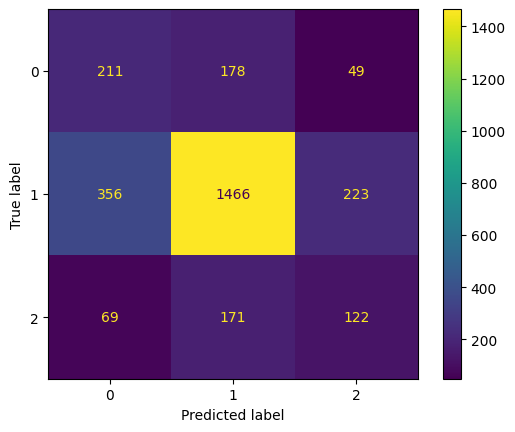

In [ ]:
ConfusionMatrixDisplay.from_predictions(labels, preds)

# Inference model

## Dependencies

In [ ]:
%%capture
!pip install natasha
!pip install transformers

In [ ]:
from natasha import (Doc, NewsNERTagger, NewsEmbedding,
                     Segmenter, MorphVocab,NewsMorphTagger,
                     NewsSyntaxParser)

from collections import defaultdict

from typing import Dict, List, Optional

from itertools import chain

from transformers import pipeline

In [ ]:
# For examples

from pprint import pprint

In [ ]:
class NERTagger:
    def __init__(self):
        self.morph_vocab = MorphVocab()

        emb = NewsEmbedding()
        self.ner_tagger = NewsNERTagger(emb)
        self.segmenter = Segmenter()
        self.morph_tagger = NewsMorphTagger(emb)
        self.syntax_parser = NewsSyntaxParser(emb)

    def get_samples(self, text:str, mask: bool = True, force: bool = False) -> Dict[str, List[str]]:
        """
        Calculates data for model inference

        If mask=True, replace organization name to [MASK].

        Output format:
        {
            "OrgName 1": ["Sample1", "Sample 2"],
            "OrgName 2": ["Sample1", "Sample 2"]
        }
        """
        doc = Doc(text)

        doc.segment(self.segmenter)
        doc.tag_morph(self.morph_tagger)
        doc.parse_syntax(self.syntax_parser)
        doc.tag_ner(self.ner_tagger)

        orgs = defaultdict(list)

        for sent in doc.sents:
            for span in sent.spans:
                if span.type != "ORG":
                    continue

                text = sent.text
                if mask:
                    text = text[:span.start - sent.start] + "[MASK]" + text[span.stop - sent.start:]

                span.normalize(self.morph_vocab)
                orgs[span.normal].append(text)

        return dict(**orgs)

In [ ]:
text = df.sample(1).text.values[0]
pprint(NERTagger().get_samples(text))

{'News.ru': ['На дискриминацию путешественников из России девушка пожаловалась '
             '[MASK].'],
 'Turkish Airlines': ['По словам россиянки, авиакомпания [MASK], рейсом '
                      'которой она должна улететь из Стамбула, заявила, что не '
                      'обязана предоставлять своим клиентам размещение в '
                      'гостинице, так как невозможно куда-то отправить '
                      'туристов из-за отсутствия сообщения с городом ввиду '
                      'сильного снегопада.'],
 'Лента.ру': ['Забрали туристов из США, Марокко и Италии, они не торчат в '
              'аэропорту, а нам говорят, что сообщения (со Стамбулом — прим. '
              '«[MASK]») нет», — передает слова россиянки издание.'],
 'Победа': ['Ранее в январе сообщалось, что 370 пассажиров авиакомпании '
            '«[MASK]» не могут вылететь из аэропорта Стамбула из-за погодных '
            'условий.']}


In [ ]:
from nltk.metrics.distance import edit_distance

In [ ]:
class Prediction:
    """
    Класс для хранения предсказаний модели

    Можно объединять два предсказания (& - пересечение, | - объединение)

    Примеры:
    >>> p1 = Prediction({"org1": [1, 0, 1, 2]})
    >>> p2 = Prediction({"org1": [1], "org2": [0]})
    >>> p1 | p2
    Prediction({"org1": [1, 0, 1, 2, 1]})
    >>> p1 & p2
    Prediction({"org1": [1, 0, 1, 2, 1], "org2": [0]})
    """

    data: Optional[Dict[str, List[int]]] = None
    samples: Optional[Dict[str, List[str]]] = None

    def __init__(self, data=None, samples=None):
        if data is None:
            data = dict()
            samples = dict()
        self.data = data
        self.samples = samples
        self.union_keys()

    def get_labels(self) -> Dict[str, List[int]]:
        """Возвращает человеко-читаемые результаты"""
        cls_labels = ["Negative", "Neutral", "Positive"]
        return {k: [cls_labels[x] for x in v] for k, v in self.data.items()}

    def get_rate(self) -> Dict[str, float]:
        """
        Возвращает усреднённое значение, где ближе к -1 -- отрицательная,
        а ближе к 1 -- положительная
        """
        return {k: sum(v) / len(v) - 1 for k, v in self.data.items()}

    def __and__(self, other):
        result = dict()
        for k, v in self.data.items():
            if k in other.data:
                result[k] = v + other.data[k]
        return Prediction(result)

    def __or__(self, other):
        result = dict()
        for k in chain(self.data.keys(), other.data.keys()):
            result[k] = self.data.get(k, []) + other.data.get(k, [])
        return Prediction(result)

    def __str__(self):
        return f"Prediction({str(self.data)})"

    def __repr__(self):
        return str(self)

    def union_keys(self):
        '''
        Очищает из ключей сущности, которые расхожи не больше, чем на 2

        Работает медленно (квадратичная асимптотика)
        '''
        orgs = list(self.data.keys())

        for i in range(len(orgs)):
            for j in range(i + 1, len(orgs)):
                if edit_distance(orgs[i], orgs[j]) <= 2:
                    mi, ma = sorted((orgs[i], orgs[j]), key=len)
                    self.data[mi] += self.data[ma]
                    del self.data[ma]

In [ ]:
class SAModel:
    def __init__(self, model_path):
        self.pipe = pipeline("text-classification", model=model_path)
        self.tagger = NERTagger()

    def predict(self, text: str) -> Prediction:
        samples = self.tagger.get_samples(text)
        texts = sum((x[1] for x in list(samples.items())), start=[])

        preds = [int(x["label"][-1]) for x in self.pipe(texts)]

        result = dict()
        i = 0
        for org, org_texts in samples.items():
            result[org] = [preds[i] for i in range(i, i + len(org_texts))]

        return Prediction(result, samples)

In [ ]:
class SAModel:
    def __init__(self, model_path1, model_path2):
        self.pipe1 = pipeline("text-classification", model=model_path1)
        self.pipe2 = pipeline("text-classification", model=model_path2)
        self.tagger = NERTagger()

    def predict(self, text: str) -> Prediction:
        samples = self.tagger.get_samples(text)
        texts = sum((x[1] for x in list(samples.items())), start=[])

        preds1 = np.array([int(x["label"][-1]) for x in self.pipe1(texts)])
        preds2 = np.array([int(x["label"][-1]) for x in self.pipe2(texts)])

        preds = preds1
        preds *= (preds2 + 1)

        preds = [1 if x == 0 else (0 if x == 1 else 2) for x in preds]

        result = dict()
        i = 0
        for org, org_texts in samples.items():
            result[org] = [preds[i] for i in range(i, i + len(org_texts))]

        return Prediction(result, samples)

In [ ]:
model = SAModel(data_path / "bert3")

In [ ]:
text = df.sample(1).text.values[0]

In [ ]:
p = model.predict(text)

In [ ]:
p.get_rate()

{'Вооруженные силы': 0.0,
 'Лента.ру': -0.5,
 'Вооруженные силы Украины (ВСУ)': 0.0}

In [ ]:
p.get_labels()

In [ ]:
p = Prediction({"Сбербанк": []})
for text in (df[df.text.str.contains("Сбербанк")].head(10).text):
    p1 = model.predict(text)
    p = p | p1
    # print(p.data, p1.data)

In [ ]:
p.get_labels()